# Análisis de Siniestros de Vivienda: Severidad, Prima Indicativa y Simulación

## Resumen
Este proyecto analiza un conjunto de siniestros de vivienda y un padrón de viviendas estimadas por sector. Se realizan: (1) análisis exploratorio de la severidad (costos), (2) ajuste de distribuciones para modelar severidad, (3) estimación de métricas por sector (frecuencia, costo total, exposición) para construir una prima indicativa, (4) ejemplos de impacto de deducible y coaseguro, y (5) una simulación tipo Monte Carlo para explorar escenarios agregados.

## Datos
Fuente: archivo `Siniestros_vivienda_proyecto_final.xlsx` con las hojas:
- `DB_SINIESTRO`: registros de siniestros (incluye columna `COSTO` y `SECTOR`).
- `VIVIENDAS_ESTIMADAS`: exposición (viviendas estimadas) por `SECTOR`.

## Cómo ejecutar
1. Coloca `Siniestros_vivienda_proyecto_final.xlsx` en el mismo directorio que este notebook.
2. Ejecuta las celdas en orden.

Nota: se mantiene el código original en lo esencial y se refuerza la documentación para uso en portafolio.


In [2]:
# ----------- Importación de Librerías y Carga de Datos -----------

# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos desde el archivo Excel
siniestros = pd.read_excel('Siniestros_vivienda_proyecto_final.xlsx', sheet_name='DB_SINIESTRO')
viviendas = pd.read_excel('Siniestros_vivienda_proyecto_final.xlsx', sheet_name='VIVIENDAS_ESTIMADAS')

# Renombrar columnas para facilidad
siniestros.rename(columns={'COSTO EN SESTERCIOS': 'COSTO',
                           'ANTIGUEDAD VIVIENDA': 'ANTIGUEDAD'}, inplace=True)

print("Datos cargados correctamente.")


Datos cargados correctamente.


# 1. Severidad: análisis de costos y ajuste de distribuciones


En esta sección se explora la distribución empírica del costo y se evalúan ajustes paramétricos (Normal, Log-normal, Gamma) mediante pruebas de bondad de ajuste y comparación visual.


count    1.000000e+05
mean     1.897289e+05
std      2.279167e+05
min      3.983000e+03
25%      6.117200e+04
50%      1.172720e+05
75%      2.350370e+05
max      2.373135e+06
Name: COSTO, dtype: float64


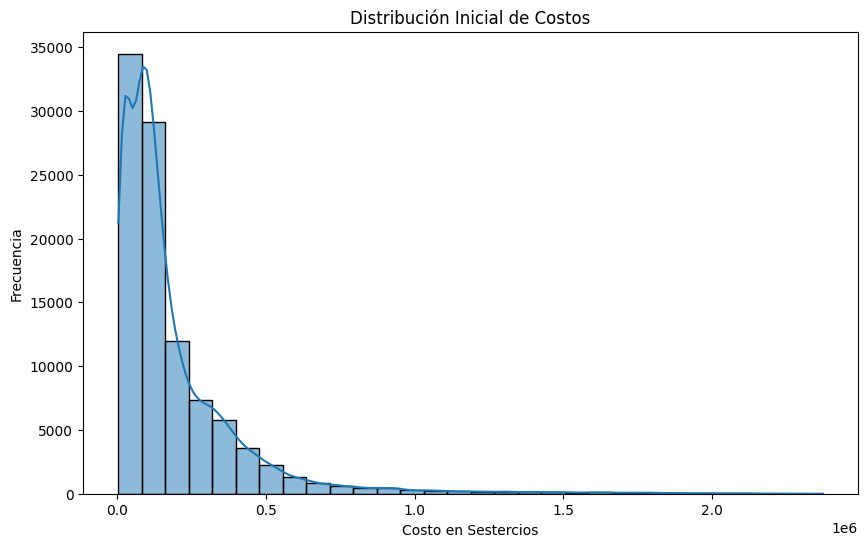

In [3]:
# Estadísticas descriptivas
print(siniestros['COSTO'].describe())

# Histogramas iniciales
plt.figure(figsize=(10, 6))
sns.histplot(siniestros['COSTO'], kde=True, bins=30)
plt.title('Distribución Inicial de Costos')
plt.xlabel('Costo en Sestercios')
plt.ylabel('Frecuencia')
plt.show()


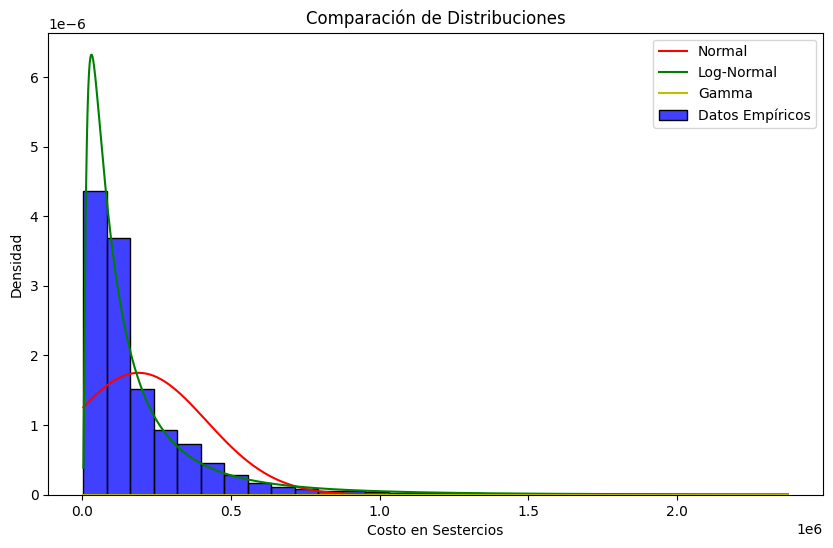

In [4]:
from scipy.stats import norm, lognorm, gamma

# Parámetros de las distribuciones
mu, sigma = norm.fit(siniestros['COSTO'])
shape, loc, scale = lognorm.fit(siniestros['COSTO'])
gamma_shape, gamma_loc, gamma_scale = gamma.fit(siniestros['COSTO'])

# Histograma empírico
plt.figure(figsize=(10, 6))
sns.histplot(siniestros['COSTO'], kde=False, bins=30, color='blue', label='Datos Empíricos', stat='density')

# Distribuciones ajustadas
x = np.linspace(siniestros['COSTO'].min(), siniestros['COSTO'].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal')
plt.plot(x, lognorm.pdf(x, shape, loc, scale), 'g-', label='Log-Normal')
plt.plot(x, gamma.pdf(x, gamma_shape, gamma_loc, gamma_scale), 'y-', label='Gamma')

plt.title('Comparación de Distribuciones')
plt.xlabel('Costo en Sestercios')
plt.ylabel('Densidad')
plt.legend()
plt.show()


In [5]:
from scipy.stats import kstest

# Pruebas KS
ks_normal = kstest(siniestros['COSTO'], 'norm', args=(mu, sigma))
ks_lognormal = kstest(siniestros['COSTO'], 'lognorm', args=(shape, loc, scale))
ks_gamma = kstest(siniestros['COSTO'], 'gamma', args=(gamma_shape, gamma_loc, gamma_scale))

# Resultados
print("KS para Normal:", ks_normal)
print("KS para Log-Normal:", ks_lognormal)
print("KS para Gamma:", ks_gamma)

KS para Normal: KstestResult(statistic=np.float64(0.2120157772925249), pvalue=np.float64(0.0), statistic_location=np.int64(8966), statistic_sign=np.int8(-1))
KS para Log-Normal: KstestResult(statistic=np.float64(0.06453736099971752), pvalue=np.float64(0.0), statistic_location=np.int64(78474), statistic_sign=np.int8(-1))
KS para Gamma: KstestResult(statistic=np.float64(0.99576), pvalue=np.float64(0.0), statistic_location=np.int64(1558940), statistic_sign=np.int8(1))


In [6]:
from scipy.stats import anderson

# Anderson-Darling para Normal
ad_result = anderson(siniestros['COSTO'], dist='norm')
print("Anderson-Darling para Normal:", ad_result)

Anderson-Darling para Normal: AndersonResult(statistic=np.float64(8021.5595449389075), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(189728.92728), scale=np.float64(227916.6537353252))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


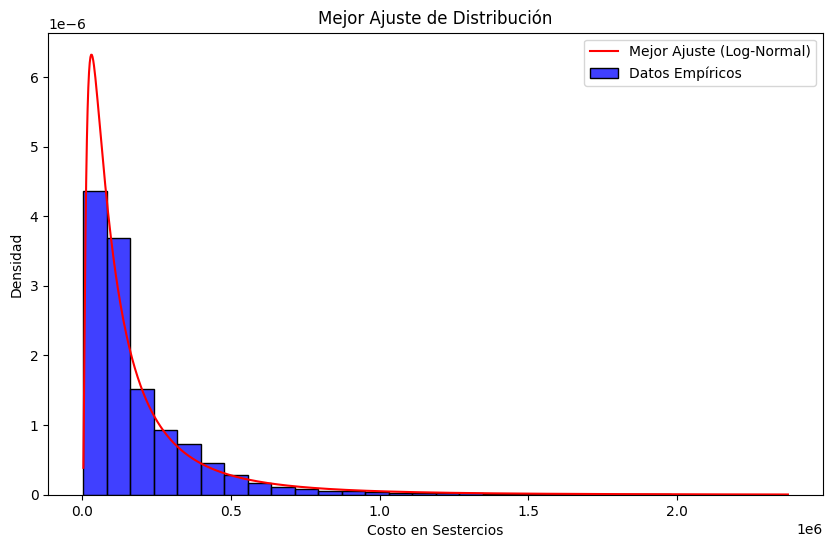

In [7]:
# Gráfico final con la mejor distribución
plt.figure(figsize=(10, 6))
sns.histplot(siniestros['COSTO'], kde=False, bins=30, color='blue', label='Datos Empíricos', stat='density')
plt.plot(x, lognorm.pdf(x, shape, loc, scale), 'r-', label='Mejor Ajuste (Log-Normal)')
plt.title('Mejor Ajuste de Distribución')
plt.xlabel('Costo en Sestercios')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# 2. Agregación por sector: frecuencia, costo total y exposición


Se agregan siniestros por sector para estimar frecuencia y costo total, y se integra la exposición (viviendas estimadas) para calcular un indicador de riesgo por vivienda.


Se consolidó la agregación por sector y el cálculo de prima indicativa en una sola sección, incluyendo validación explícita de columnas para evitar errores por nombres inconsistentes.

In [8]:
# 2-3. Agregación por sector y prima indicativa (con validación)

# Estandarizar nombres de columnas en ambos DataFrames
siniestros.columns = siniestros.columns.str.strip()
viviendas.columns = viviendas.columns.str.strip()

# Renombrar columnas esperadas en VIVIENDAS_ESTIMADAS (según archivo original)
viviendas = viviendas.rename(columns={
    'Sector1': 'SECTOR',
    'Viviendas estimadas1': 'VIVIENDAS_ESTIMADAS'
})

# Validación explícita de columnas requeridas
req_siniestros = {'SECTOR', 'NUM_SIN', 'COSTO'}
req_viviendas  = {'SECTOR', 'VIVIENDAS_ESTIMADAS'}

missing_sin = req_siniestros.difference(set(siniestros.columns))
missing_viv = req_viviendas.difference(set(viviendas.columns))

if missing_sin or missing_viv:
    raise ValueError(
        "Columnas faltantes detectadas. "
        f"siniestros faltan: {sorted(missing_sin)}; "
        f"viviendas faltan: {sorted(missing_viv)}. "
        f"Columnas siniestros: {list(siniestros.columns)}; "
        f"Columnas viviendas: {list(viviendas.columns)}"
    )

# Agregar siniestros por sector
sector_siniestros = (
    siniestros.groupby('SECTOR')
    .agg(
        frecuencia_siniestros=('NUM_SIN', 'count'),
        costo_total_siniestros=('COSTO', 'sum')
    )
    .reset_index()
)

# Unir exposición (viviendas estimadas) por sector
sector_riesgo = sector_siniestros.merge(
    viviendas[['SECTOR', 'VIVIENDAS_ESTIMADAS']],
    on='SECTOR',
    how='left',
    validate='one_to_one'
)

# Identificar sectores sin exposición (para no dividir entre NaN)
sin_exposicion = sector_riesgo[sector_riesgo['VIVIENDAS_ESTIMADAS'].isna()]['SECTOR'].tolist()
if sin_exposicion:
    print("Aviso: hay sectores sin viviendas estimadas (quedarán como NaN):", sin_exposicion)

# Índice simple de riesgo (costo por vivienda estimada)
sector_riesgo['riesgo_por_vivienda'] = (
    sector_riesgo['costo_total_siniestros'] / sector_riesgo['VIVIENDAS_ESTIMADAS']
)

# 3. Prima indicativa promedio por sector (aproximación)
tasa_carga = 1.2
sector_riesgo['prima_estimado_promedio'] = sector_riesgo['riesgo_por_vivienda'] * tasa_carga

sector_riesgo[['SECTOR', 'frecuencia_siniestros', 'costo_total_siniestros', 'VIVIENDAS_ESTIMADAS', 'riesgo_por_vivienda', 'prima_estimado_promedio']].sort_values('SECTOR')


,SECTOR,frecuencia_siniestros,costo_total_siniestros,VIVIENDAS_ESTIMADAS,riesgo_por_vivienda,prima_estimado_promedio
0,Aventino y Testaccio,13397,2758047506,20000,137902.375300,1.654829e+05
1,Campo de Marte,3662,1017716857,5000,203543.371400,2.442520e+05
2,Foro Romano y Palatino,7748,3995094433,4000,998773.608250,1.198528e+06
3,Monte Celio y Esquilino,8407,2897617593,8000,362202.199125,4.346426e+05
4,Murallas Servianas (periferia),9420,1135247443,10000,113524.744300,1.362297e+05
5,Ostia (Puerto),11172,1723130209,12000,143594.184083,1.723130e+05
6,Subura,26751,2770091109,50000,55401.822180,6.648219e+04
7,Trastevere,19443,2675947578,15000,178396.505200,2.140758e+05


/tmp/ipython-input-2336577733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SECTOR', y='costo_total_siniestros', data=sector_riesgo, palette='viridis')
/tmp/ipython-input-2336577733.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SECTOR', y='riesgo_por_vivienda', data=sector_riesgo, palette='magma')


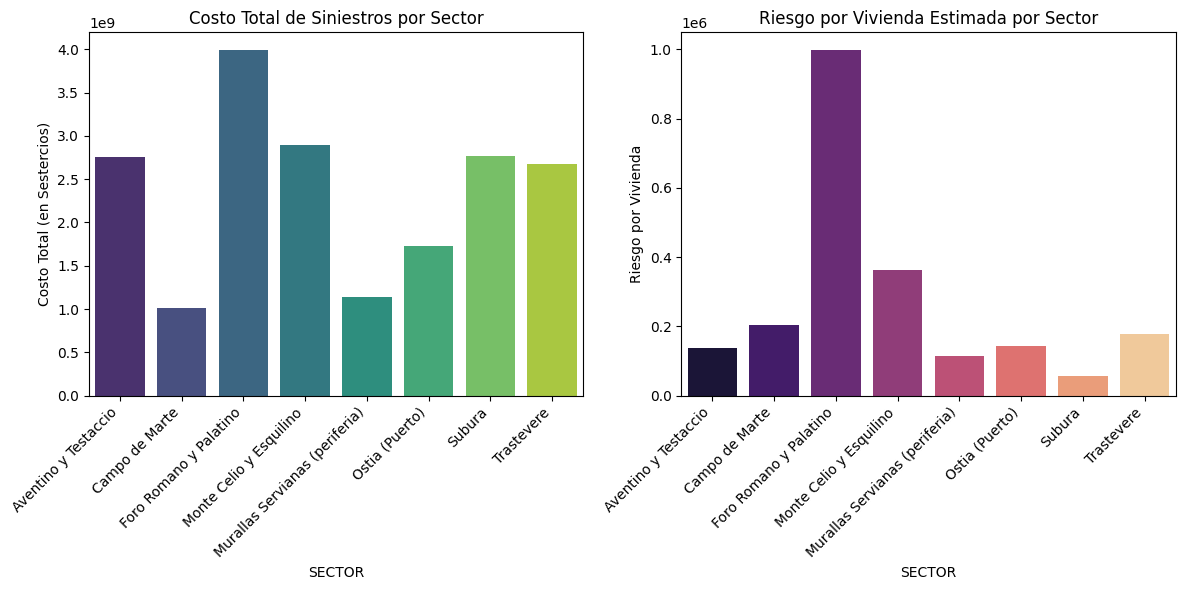

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de gráficos
plt.figure(figsize=(12, 6))

# Gráfico de barras: Costo total de siniestros por sector
plt.subplot(1, 2, 1)
sns.barplot(x='SECTOR', y='costo_total_siniestros', data=sector_riesgo, palette='viridis')
plt.title('Costo Total de Siniestros por Sector')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Costo Total (en Sestercios)')

# Gráfico de barras: Riesgo por vivienda estimada por sector
plt.subplot(1, 2, 2)
sns.barplot(x='SECTOR', y='riesgo_por_vivienda', data=sector_riesgo, palette='magma')
plt.title('Riesgo por Vivienda Estimada por Sector')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Riesgo por Vivienda')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# 4. Ejemplo: efecto del deducible


Ejemplo con valores tomados de la muestra (no datos inventados) para ilustrar cómo el deducible reduce la participación del asegurador.


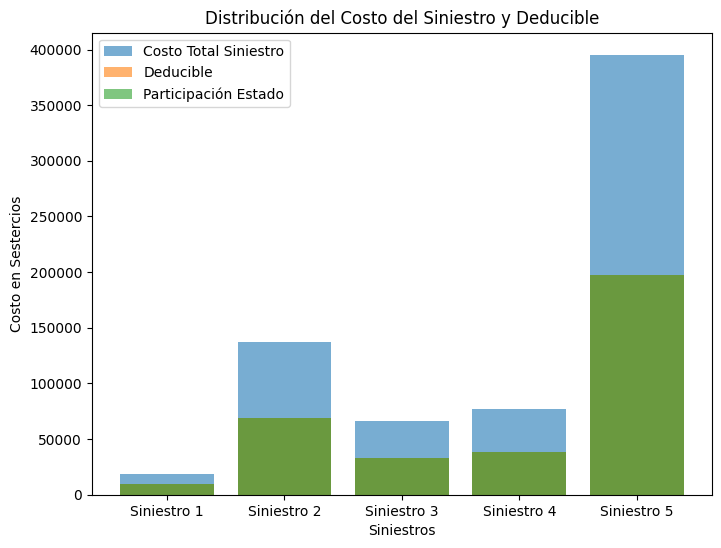

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar una muestra representativa de costos reales (5 observaciones)
costos_siniestros = siniestros['COSTO'].dropna().sample(5, random_state=42).values
deducibles = 0.5 * costos_siniestros  # Deducible mínimo del 50%
participacion_estado = costos_siniestros - deducibles  # La participación del Estado es el costo - el deducible

# Crear las gráficas
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar barras para cada componente
ax.bar(range(len(costos_siniestros)), costos_siniestros, label='Costo Total Siniestro', alpha=0.6)
ax.bar(range(len(deducibles)), deducibles, label='Deducible', alpha=0.6)
ax.bar(range(len(participacion_estado)), participacion_estado, label='Participación Estado', alpha=0.6)

# Etiquetas y leyenda
ax.set_xlabel('Siniestros')
ax.set_ylabel('Costo en Sestercios')
ax.set_title('Distribución del Costo del Siniestro y Deducible')
ax.legend()

# Mostrar el gráfico
plt.xticks(range(len(costos_siniestros)), [f'Siniestro {i+1}' for i in range(len(costos_siniestros))])
plt.show()


# 5. Ejemplo: efecto del coaseguro


Ejemplo con un siniestro representativo para ilustrar la distribución del costo entre asegurado y asegurador tras aplicar deducible y coaseguro.


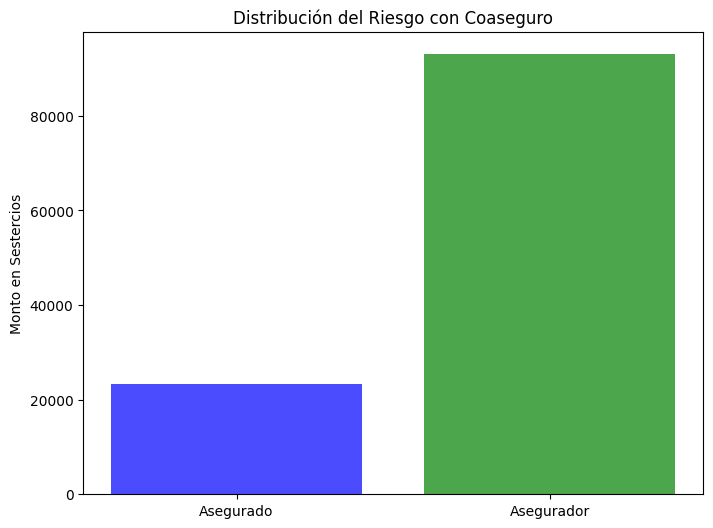

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar un siniestro representativo (mediana) para el ejemplo
costo_total = float(siniestros['COSTO'].dropna().median())  # Costo total representativo
deducible = 1000  # Deducible
coaseguro_porcentaje = 0.2  # El asegurado paga el 20%

# Cálculos
costo_restante = costo_total - deducible
participacion_asegurado = coaseguro_porcentaje * costo_restante
participacion_asegurador = (1 - coaseguro_porcentaje) * costo_restante

# Crear las gráficas
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar barras para cada componente
ax.bar(['Asegurado', 'Asegurador'], [participacion_asegurado, participacion_asegurador], color=['blue', 'green'], alpha=0.7)

# Etiquetas y leyenda
ax.set_ylabel('Monto en Sestercios')
ax.set_title('Distribución del Riesgo con Coaseguro')

# Mostrar el gráfico
plt.show()


In [12]:
print(sector_riesgo.columns)


Index(['SECTOR', 'frecuencia_siniestros', 'costo_total_siniestros',
       'VIVIENDAS_ESTIMADAS', 'riesgo_por_vivienda',
       'prima_estimado_promedio'],
      dtype='object')


In [13]:
# Suponiendo que la frecuencia de siniestros es un buen indicador de riesgo
sector_riesgo['coef_riesgo'] = sector_riesgo['frecuencia_siniestros'].apply(
    lambda x: 1 if x <= 5 else (2 if x <= 15 else 3)
)


In [14]:
# Suponiendo que el costo total de siniestros es un buen indicador de riesgo
sector_riesgo['coef_riesgo'] = sector_riesgo['costo_total_siniestros'].apply(
    lambda x: 1 if x <= 100000 else (2 if x <= 500000 else 3)
)


In [15]:
# Analizar la correlación entre frecuencia y costo
correlation = sector_riesgo[['frecuencia_siniestros', 'costo_total_siniestros']].corr()
print(correlation)


                        frecuencia_siniestros  costo_total_siniestros
frecuencia_siniestros                1.000000                0.286759
costo_total_siniestros               0.286759                1.000000


In [16]:
# Crear coeficiente de riesgo con umbrales más pequeños para frecuencia
sector_riesgo['coef_riesgo_freq'] = sector_riesgo['frecuencia_siniestros'].apply(
    lambda x: 1 if x <= 5 else (1.5 if x <= 10 else (2 if x <= 15 else (2.5 if x <= 25 else 3)))
)

# Crear coeficiente de riesgo con umbrales más pequeños para costo
sector_riesgo['coef_riesgo_costo'] = sector_riesgo['costo_total_siniestros'].apply(
    lambda x: 1 if x <= 100000 else (1.5 if x <= 300000 else (2 if x <= 500000 else (2.5 if x <= 1000000 else 3)))
)


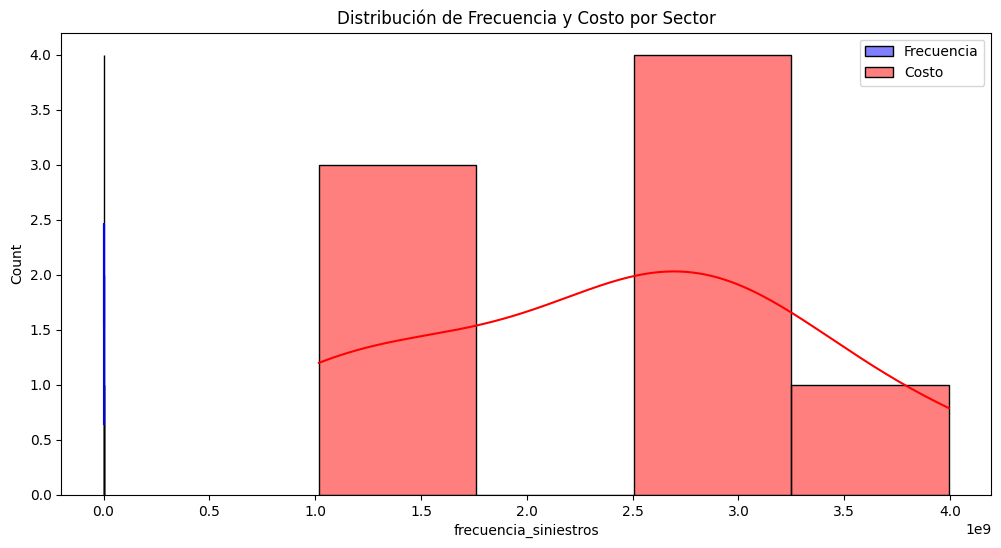

In [17]:
import seaborn as sns
plt.figure(figsize=(12, 6))

# Graficar la distribución de frecuencia
sns.histplot(sector_riesgo['frecuencia_siniestros'], kde=True, color='blue', label='Frecuencia')

# Graficar la distribución de costo
sns.histplot(sector_riesgo['costo_total_siniestros'], kde=True, color='red', label='Costo')

plt.legend()
plt.title('Distribución de Frecuencia y Costo por Sector')
plt.show()


In [18]:
def ajustar_coaseguro(riesgo_sector):
    if riesgo_sector <= 100000:  # Bajo riesgo
        return 0.30  # 30% coaseguro para el asegurado
    elif riesgo_sector <= 300000:  # Riesgo moderado
        return 0.20  # 20% coaseguro para el asegurado
    else:  # Alto riesgo
        return 0.10  # 10% coaseguro para el asegurado


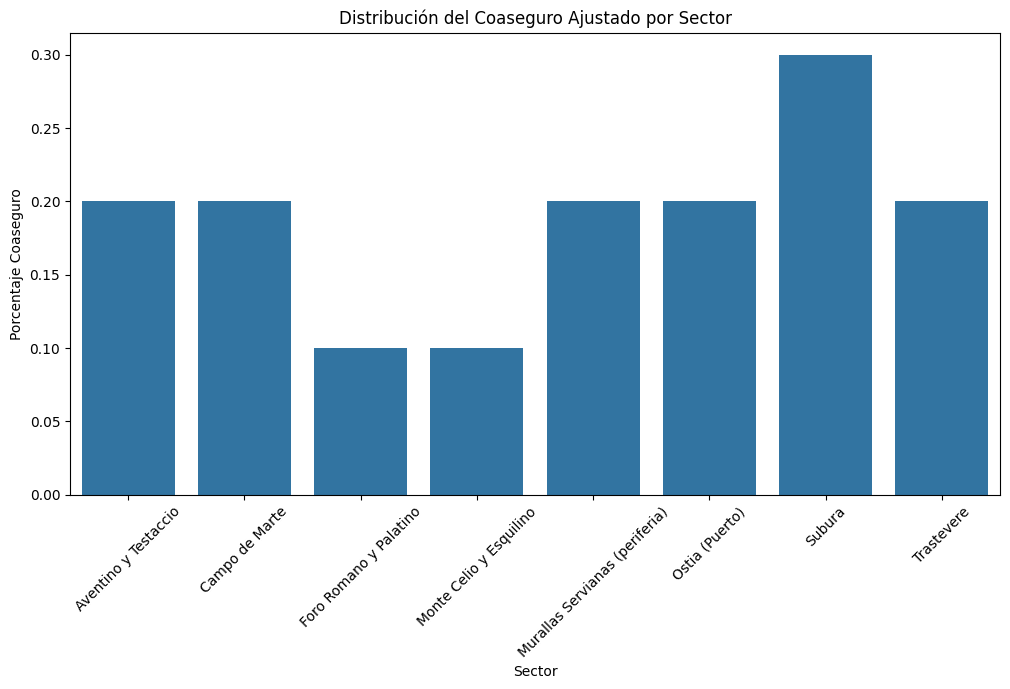

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la función para calcular el coaseguro
sector_riesgo['coaseguro_ajustado'] = sector_riesgo['riesgo_por_vivienda'].apply(ajustar_coaseguro)

# Mostrar gráficos de distribución del coaseguro por sector
plt.figure(figsize=(12, 6))
sns.barplot(x='SECTOR', y='coaseguro_ajustado', data=sector_riesgo)
plt.title('Distribución del Coaseguro Ajustado por Sector')
plt.ylabel('Porcentaje Coaseguro')
plt.xlabel('Sector')
plt.xticks(rotation=45)
plt.show()


In [20]:
def ajustar_coaseguro_por_riesgo(row):
    if row['coef_riesgo'] > 1.5:
        return 0.30  # Coaseguro mayor si el riesgo es alto
    else:
        return 0.15  # Coaseguro menor si el riesgo es bajo

# Aplicar la función al DataFrame
sector_riesgo['coaseguro_ajustado_riesgo'] = sector_riesgo.apply(ajustar_coaseguro_por_riesgo, axis=1)

# Ver los resultados
print(sector_riesgo[['SECTOR', 'coaseguro_ajustado_riesgo']])


                           SECTOR  coaseguro_ajustado_riesgo
0            Aventino y Testaccio                        0.3
1                  Campo de Marte                        0.3
2          Foro Romano y Palatino                        0.3
3         Monte Celio y Esquilino                        0.3
4  Murallas Servianas (periferia)                        0.3
5                  Ostia (Puerto)                        0.3
6                          Subura                        0.3
7                      Trastevere                        0.3


In [21]:
def ajustar_coaseguro_por_frecuencia_costo(row):
    if row['frecuencia_siniestros'] > 0.1 and row['costo_total_siniestros'] > 10000:
        return 0.30  # Coaseguro mayor en sectores de alto riesgo
    else:
        return 0.15  # Coaseguro menor en sectores de bajo riesgo

# Aplicar la función al DataFrame
sector_riesgo['coaseguro_ajustado_freq_costo'] = sector_riesgo.apply(ajustar_coaseguro_por_frecuencia_costo, axis=1)

# Ver los resultados
print(sector_riesgo[['SECTOR', 'coaseguro_ajustado_freq_costo']])


                           SECTOR  coaseguro_ajustado_freq_costo
0            Aventino y Testaccio                            0.3
1                  Campo de Marte                            0.3
2          Foro Romano y Palatino                            0.3
3         Monte Celio y Esquilino                            0.3
4  Murallas Servianas (periferia)                            0.3
5                  Ostia (Puerto)                            0.3
6                          Subura                            0.3
7                      Trastevere                            0.3


# 6. Simulación (Monte Carlo) de escenarios agregados


Se simula el número de siniestros y el costo agregado bajo supuestos paramétricos, con el fin de explorar variabilidad y posibles rangos de resultados.


In [22]:
import numpy as np
import pandas as pd

# Parámetros iniciales basados en los datos
frecuencia_media = sector_riesgo['frecuencia_siniestros'].mean()  # Frecuencia promedio
media_costo = sector_riesgo['costo_total_siniestros'].mean()  # Media del costo
desv_costo = sector_riesgo['costo_total_siniestros'].std()  # Desviación estándar del costo

# Número de simulaciones
n_simulaciones = 10000


In [23]:
# Simular el número de siniestros (distribución Poisson)
siniestros_simulados = np.random.poisson(lam=frecuencia_media, size=n_simulaciones)

# Simular los costos asociados a los siniestros (distribución Log-normal)
costos_simulados = np.random.lognormal(mean=np.log(media_costo), sigma=np.log(desv_costo), size=n_simulaciones)

# Crear un DataFrame para los resultados
simulacion = pd.DataFrame({
    'siniestros': siniestros_simulados,
    'costo_siniestros': costos_simulados
})

# Calcular métricas agregadas
simulacion['costo_total'] = simulacion['siniestros'] * simulacion['costo_siniestros']


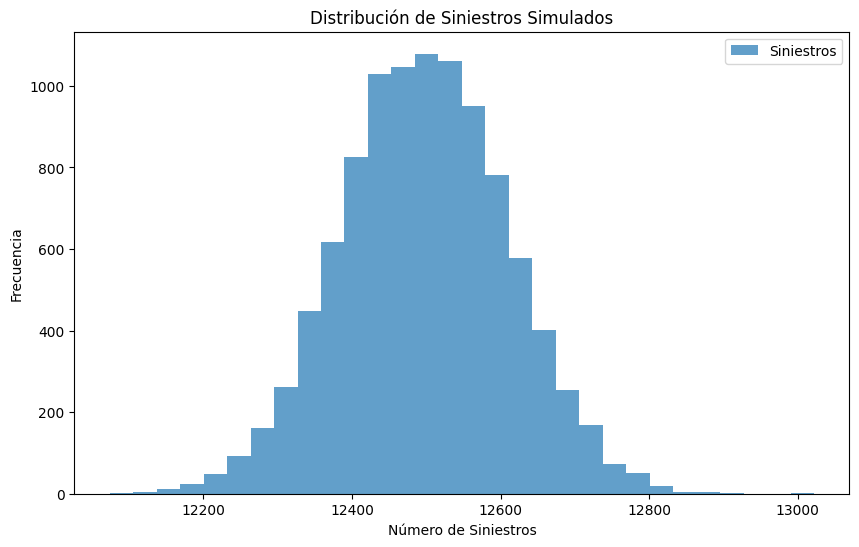

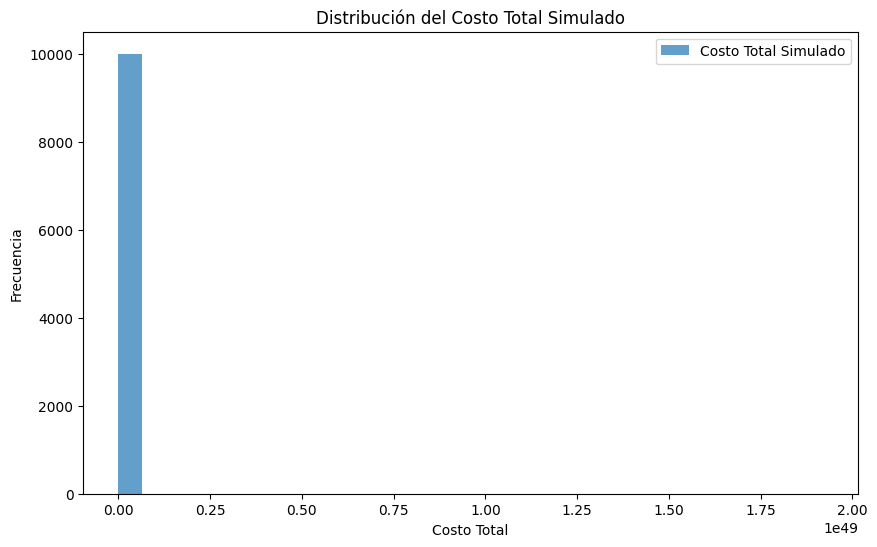

In [24]:
import matplotlib.pyplot as plt

# Resumen estadístico
resumen_simulacion = simulacion.describe()

# Graficar la distribución de los siniestros
plt.figure(figsize=(10, 6))
plt.hist(simulacion['siniestros'], bins=30, alpha=0.7, label='Siniestros')
plt.title('Distribución de Siniestros Simulados')
plt.xlabel('Número de Siniestros')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Graficar la distribución de costos
plt.figure(figsize=(10, 6))
plt.hist(simulacion['costo_total'], bins=30, alpha=0.7, label='Costo Total Simulado')
plt.title('Distribución del Costo Total Simulado')
plt.xlabel('Costo Total')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()
